<a href="https://colab.research.google.com/github/trifarameliniaa/Belajar_AI/blob/NLP/28Maret_Case_Study_NLP_01_%26_NLP_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: SMS Spam Classification
**26 Maret 2022, Review NLP_01 & NLP_02** 

Created by NLP SQUAD Orbit Future Academy<br>

Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.

![title](https://undangmi.com/wp-content/uploads/2022/03/Screen-Shot-2022-03-26-at-23.14.46.png)

Langkah-langkah penyelesaian melitputi:
1. Data collection
2. Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Extraction
   1. BoW
   2. TF-IDF
4. Feature Selection
   1. Chi-Square

Pada kasus ini, kita menggunakan data set berbahasa indonesia, sehingga kita membutuhkan *Library Sastrawi* untuk menyelesaikan beberapa permasalahan seperti *stemming*.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [ ]:
!pip -q install sastrawi

     |████████████████████████████████| 209 kB 13.3 MB/s 


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Acquisition

Penjelasan Label 
* 0: SMS normal 
* 1: SMS fraud atau penipuan 
* 2: SMS promo

In [ ]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-03-28 06:28:47--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.008s  

2022-03-28 06:28:47 (15.6 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [ ]:
data = pd.read_csv('dataset_sms_spam_v1.csv')

data.head(10)

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2
5,5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket ...,2
6,"Ada iRing dgn tarif Rp. 0,1/7hr (perpanjangan ...",2
7,Akhir bulan harus tetap eksis loh! Internetan ...,2
8,Aktifkan iRing Coboy Jr - Terhebat. Tekan *808...,2
9,Ambil bonus harianmu di *600# (Bebas Pulsa). D...,2


In [ ]:
data.tail(10)

,teks,label
1133,Yg butuh kosan perbulan bisa langsung ditempat...,0
1134,"Yg dian ge waktu itu yudisium akhirnya sore2, ...",0
1135,Yg mau ngampus aku pengen titip bawain SKL aku...,0
1136,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,0
1137,Yg sebelah warteg bahri apa sebrangnya? Yg 15,0
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0
1140,Mba mau kirim 300 ya,0
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0
1142,No bri atas nama kamu mana,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [ ]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



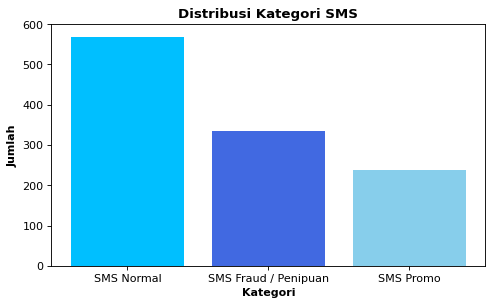

In [ ]:
height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# Text Preprocessing

## Case Folding

In [ ]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [ ]:
raw_sample = data['teks'].iloc[0]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  [PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K
Case folding	:  promo beli paket flash mulai gb di my telkomsel app dpt extra kuota gb g lte dan extra nelpon hingga mnthr buruan cek  di tselmemytsel sk


## Word Normalization

In [ ]:
# Download corpus singkatan
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-03-28 06:38:17--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.005s  

2022-03-28 06:38:17 (15.6 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [ ]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind

In [ ]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [ ]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel


## Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel
Stemming		:  ekstra pulsa dg beli paket internet bulan mytelkomsel utk beli sjk augsept cek detail promo tselmemytsel


## Text Preprocessing Pipeline

In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 4min 36s, sys: 726 ms, total: 4min 37s
Wall time: 4min 37s


In [ ]:
data

,teks,label,clean_teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash my telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,rupiah ribu spesial pilih aktif promo sd novem...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,rupiah ribu spesial pilih aktif buru skb
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mbak kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagimau cas atay tranfer


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# Feature Engineering

In [ ]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [ ]:
X

0       promo beli paket flash my telkomsel app extra ...
1       rupiah ribu spesial pilih aktif promo sd novem...
2       pulang hormat sisa kuota flash kb download myt...
3       pulang hormat sisa kuota flash kb download myt...
4                rupiah ribu spesial pilih aktif buru skb
                              ...                        
1138                           yooo oke umumin grup kelas
1139                     nulis kerudung kirain warna jins
1140                                        mbak kirim ya
1141        nama beaok bwrangkat pagimau cas atay tranfer
1142                                       nomor bri nama
Name: clean_teks, Length: 1143, dtype: object

In [ ]:
y

0       2
1       2
2       2
3       2
4       2
       ..
1138    0
1139    0
1140    0
1141    0
1142    0
Name: label, Length: 1143, dtype: int64

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [ ]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
vec = CountVectorizer(ngram_range=(1,1))
vec.fit(X)

CountVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(vec.get_feature_names_out()))

3253


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(vec.get_feature_names_out())

['aa' 'aamiiiin' 'aamiin' ... 'zjt' 'zona' 'ztkm']


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_unigram = vec.transform(X).toarray()

X_unigram

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
data_unigram = pd.DataFrame(X_unigram, columns=vec.get_feature_names_out())
data_unigram

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
with open('bow.pickle', 'wb') as output:
  pickle.dump(X_unigram, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [ ]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

X_tf_idf = tf_idf.transform(X)

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

3253


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aamiiiin' 'aamiin' ... 'zjt' 'zona' 'ztkm']


In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()

X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('tf_idf.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 3253
Reduced feature number: 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.835608
1,0.419698
2,1.558607
3,0.716455
4,0.800674
...,...
3248,1.180239
3249,0.503162
3250,0.716455
3251,2.917381


In [ ]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.835608,aa
1,0.419698,aamiiiin
2,1.558607,aamiin
3,0.716455,ab
4,0.800674,abadi
...,...,...
3248,1.180239,zalora
3249,0.503162,zarkasi
3250,0.716455,zjt
3251,2.917381,zona


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2088,49.062970,paket
1030,46.324101,hadiah
1549,45.593560,kuota
2178,39.438431,pin
1486,34.448410,klik
...,...,...
1520,0.044910,kopi
307,0.044468,bca
1694,0.031579,maksimal
531,0.013783,cepat


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False,  True, ..., False,  True, False])

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []
for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature
len(selected_feature)

1000

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,agam,agen,ags,agst,agsts,agt,agtskinfodlj,agun,agustuskunjungi,...,yesok,your,yrkz,ytg,ythmohon,ythsaya,yuk,yunit,zalora,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('best_feature.pickle', 'wb') as output:
  pickle.dump(X_kbest_features, output)

# Modelling (Machine Learning)

In [ ]:
# Coming soon

# Model Evaluation

In [ ]:
# Coming soon

# Deployment

In [ ]:
# Coming soon

# WordCloud

In [ ]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [ ]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2022-03-28 07:17:18--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0.002s  

2022-03-28 07:17:18 (16.9 MB/s) - ‘cloud.jpg’ saved [34396/34396]



In [ ]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

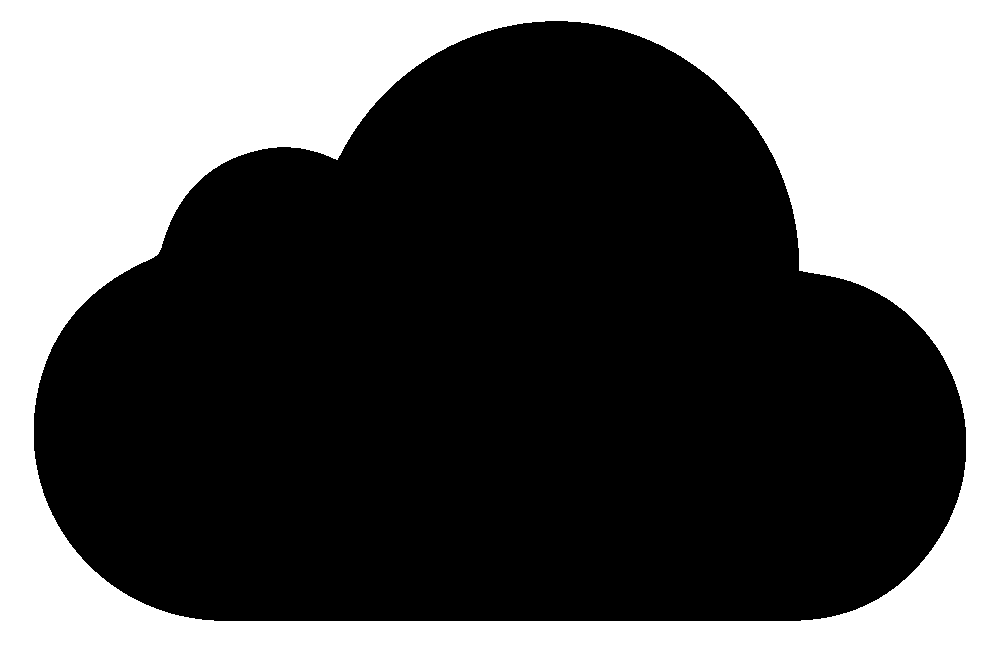

In [ ]:
# Tampilkan masking
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

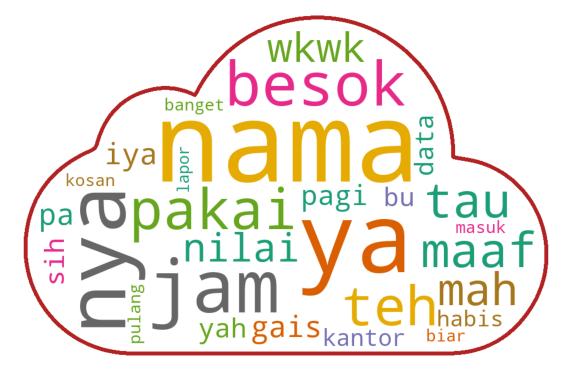

In [ ]:
# WordCloud Label SMS Normal

sms_normal = data[data.label == 0]
normal_string = []

for t in sms_normal.clean_teks:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

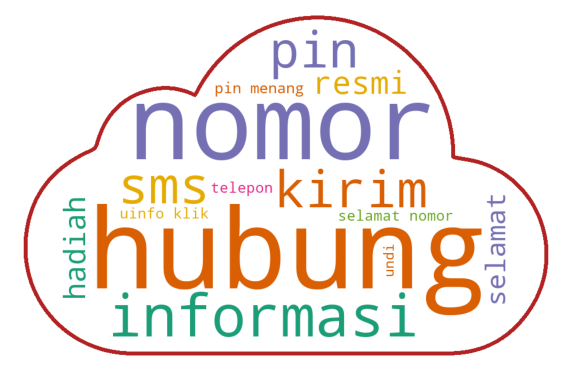

In [ ]:
# WordCloud Label SMS Fraud / Penipuan

sms_fraud = data[data.label == 1]
fraud_string = []

for t in sms_fraud.clean_teks:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

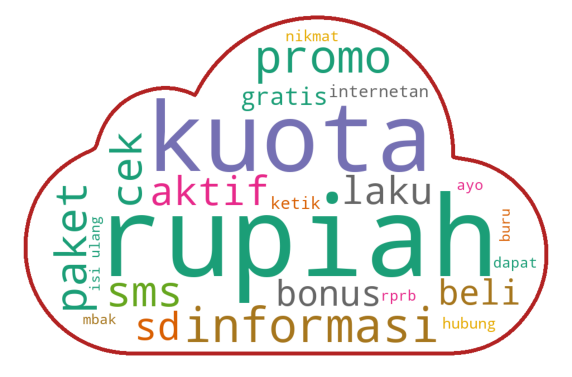

In [ ]:
# WordCloud Label SMS Promo

sms_promo = data[data.label == 2]
promo_string = []

for t in sms_promo.clean_teks:
  promo_string.append(t)

promo_string = pd.Series(promo_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(promo_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Student Activity
Lakukan proses di atas menggunakan dataset review product https://drive.google.com/file/d/1qn5WXp-H95_FL_Rx5oqvfZaflYdHsnrF/view?usp=sharing

Tugas Anda:
- Tentukan langkah pre-processing yang tepat untuk dataset di atas.
- Gunakan range `n_gram` yang berbeda. Amati apa perbedaannya.
- Menurut Anda, apakah `term` yang dihasilkan (`X_kbest_features`) pada feature selection sudah memiliki informasi yang relevan?

Setelah dikerjakan, buatlah resume berdasarkan pengalaman Anda dalam melakukan pre-processing dan feature engineering.

Kumpulkan tugas Anda pada: https://s.id/tugas-nlp-ofa

